In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
image_size = 299

# Transformation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images while maintaining aspect ratio
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [3]:
data_dir = './'
full_dataset = datasets.Food101(root=data_dir, download = True, transform=transform)

In [3]:
data_dir = '/content/food-101/images/'

In [4]:
# ImageFolder load
full_dataset = datasets.ImageFolder(root=data_dir, transform = transform)

In [5]:
# Ratio definition
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [6]:
# Split indices into training and combined validation/test indices
train_indices, test_val_indices = train_test_split(range(len(full_dataset)), test_size=(val_ratio + test_ratio), random_state=42)

# Split combined validation/test indices into separate validation and test indices
val_indices, test_indices = train_test_split(test_val_indices, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

train_set = Subset(full_dataset, train_indices)  # Subset for training data
val_set = Subset(full_dataset, val_indices)      # Subset for validation data
test_set = Subset(full_dataset, test_indices)    # Subset for test data

In [7]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [8]:
class_labels = full_dataset.classes
print(f"Class : {class_labels}")
print(f"Total number of classes: {len(class_labels)}")

Class : ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', '

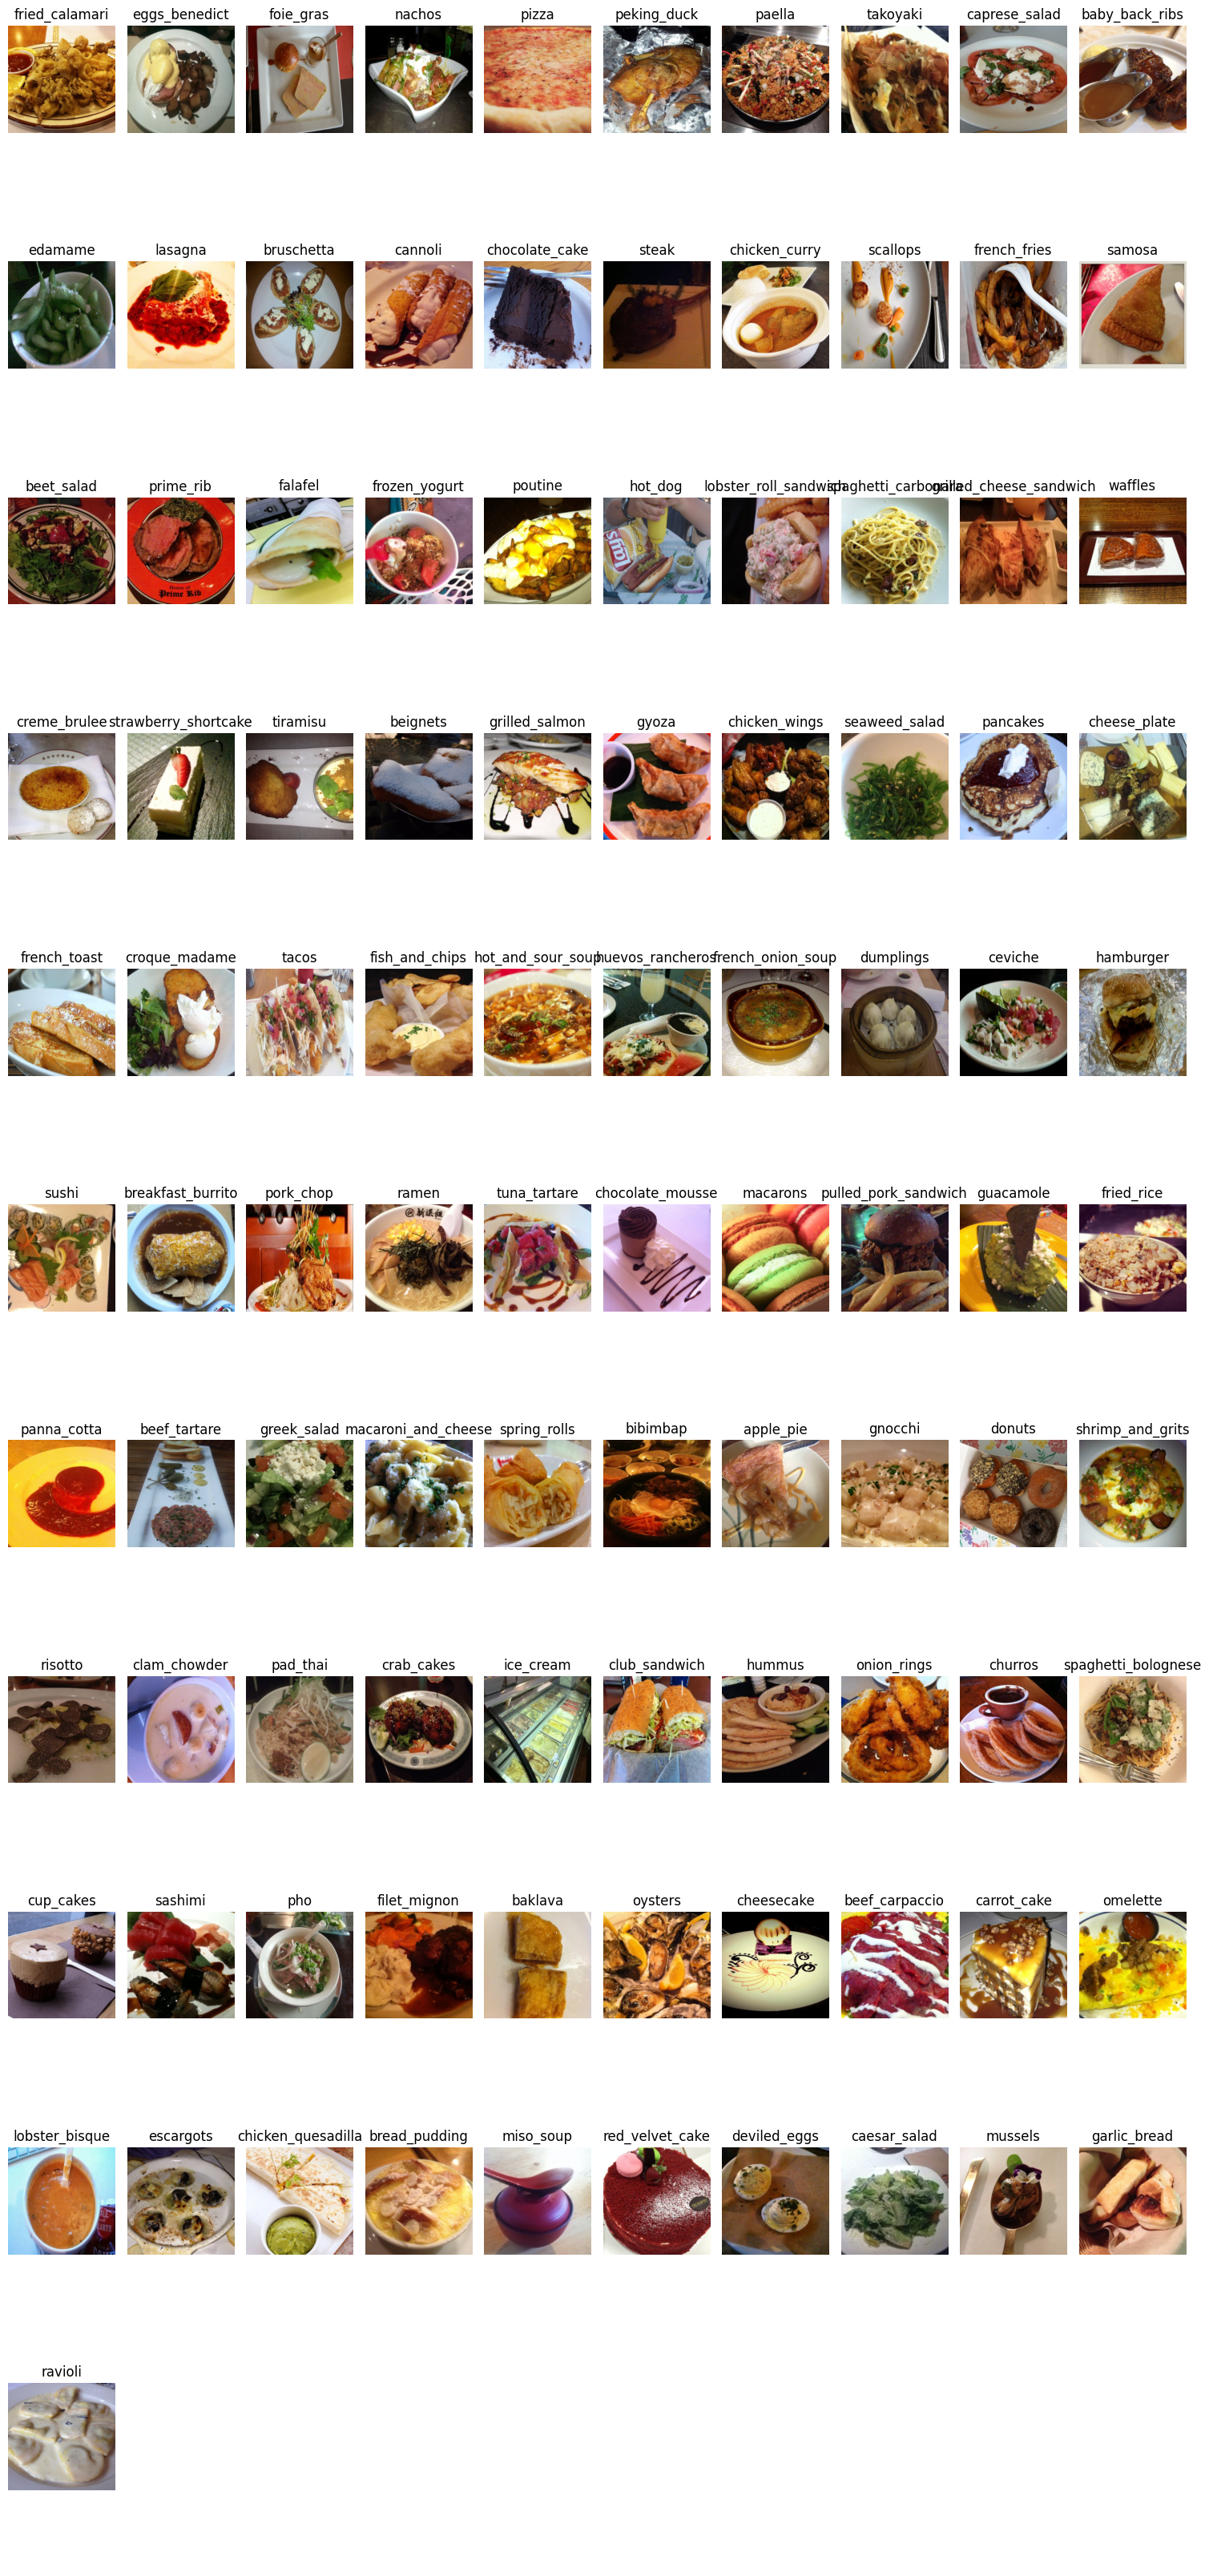

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, labels, class_labels):
    num_images = len(images)
    num_rows = (num_images + 9) // 10  # Calculate rows needed for 10 images per row
    fig, axes = plt.subplots(num_rows, 10, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, (image, label) in enumerate(zip(images, labels)):
        image = image.numpy().transpose((1, 2, 0))  # Reformat for plotting
        mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
        std = np.array([0.229, 0.224, 0.225])  # Normalization std
        image = std * image + mean  # Denormalize
        image = np.clip(image, 0, 1)  # Ensure pixel values are within [0,1]

        axes[i].imshow(image)
        axes[i].set_title(class_labels[label])  # Set image title to class label
        axes[i].axis('off')  # Turn off axes

    for j in range(num_images, num_rows * 10):
        axes[j].axis('off')  # Turn off empty subplot axes

    plt.tight_layout()
    plt.show()

images, labels = [], []
classes_found = set()
for img, lbl in train_loader:
    for image, label in zip(img, lbl):
        if class_labels[label.item()] not in classes_found:
            images.append(image)
            labels.append(label)
            classes_found.add(class_labels[label.item()])
        if len(classes_found) == len(class_labels):
            break

show_images(images, labels, class_labels)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Modified GoogleNet
class ModifiedGoogLeNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(ModifiedGoogLeNet, self).__init__()
        # Load the pre-trained GoogLeNet model
        self.feature_extractor = models.googlenet(pretrained=True)
        for param in self.feature_extractor.parameters():
          param.requires_grad = False


        for layer in [self.feature_extractor.inception5a, self.feature_extractor.inception5b]:
          for param in layer.parameters():
              param.requires_grad = True

        # Remove the original fully connected layer
        self.feature_extractor.fc = nn.Identity()

        self.dropout = nn.Dropout(0.2)

        # Add global average pooling
        self.feature_extractor.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Add three fully connected layers
        self.fc1 = nn.Linear(1024, 1000)  # First fully connected layer
        self.fc2 = nn.Linear(1000, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Final fully connected layer mapping to the number of classes

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)

        # Forward passes through the fully connected layers
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)

        return x

In [12]:
googlenet = ModifiedGoogLeNet(num_classes = 101, pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
googlenet.to(device)

ModifiedGoogLeNet(
  (feature_extractor): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR  # Import ReduceLROnPlateau scheduler from PyTorch

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, googlenet.parameters()), lr=0.00001)

In [15]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [16]:
# Early Stopping Callback
class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [17]:
custom_callback = CustomCallback()

In [18]:
custom_callback.set_optimizer(optimizer)

In [19]:
custom_callback.set_model(googlenet)

In [20]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 50  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    googlenet.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples¿???
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = googlenet(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    googlenet.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = googlenet(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/50], Train Loss: 4.0809, Train Accuracy: 0.1239, Val Loss: 3.1254, Val Accuracy: 0.2731
Epoch [2/50], Train Loss: 2.9436, Train Accuracy: 0.2934, Val Loss: 2.4579, Val Accuracy: 0.3958
Epoch [3/50], Train Loss: 2.5179, Train Accuracy: 0.3747, Val Loss: 2.1822, Val Accuracy: 0.4550
Epoch [4/50], Train Loss: 2.2806, Train Accuracy: 0.4228, Val Loss: 1.9891, Val Accuracy: 0.4894
Epoch [5/50], Train Loss: 2.1207, Train Accuracy: 0.4586, Val Loss: 1.8873, Val Accuracy: 0.5153
Epoch [6/50], Train Loss: 1.9975, Train Accuracy: 0.4878, Val Loss: 1.7921, Val Accuracy: 0.5400
Epoch [7/50], Train Loss: 1.8978, Train Accuracy: 0.5109, Val Loss: 1.7175, Val Accuracy: 0.5577
Epoch [8/50], Train Loss: 1.8137, Train Accuracy: 0.5290, Val Loss: 1.6769, Val Accuracy: 0.5647
Epoch [9/50], Train Loss: 1.7456, Train Accuracy: 0.5457, Val Loss: 1.6042, Val Accuracy: 0.5853
Epoch [10/50], Train Loss: 1.6832, Train Accuracy: 0.5598, Val Loss: 1.5781, Val Accuracy: 0.5924
Epoch [11/50], Train Loss: 1.

In [30]:
googlenet.eval()  # Set model to evaluation mode

test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss
all_preds = []
true_labels = []

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = googlenet(inputs)  # Get model predictions
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples
        all_preds.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.3865, Test Accuracy: 0.6505


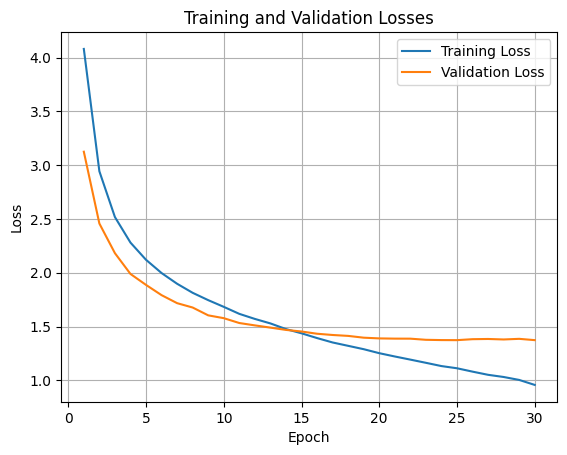

In [22]:
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

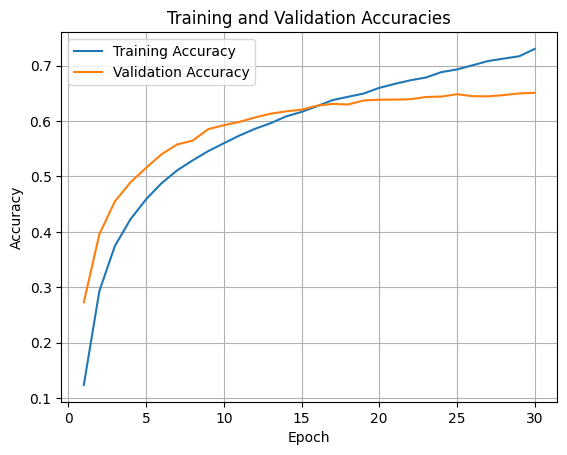

In [23]:
# Plot training and validation accuracies starting from index 1
epochs = range(1, len(train_accuracies) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

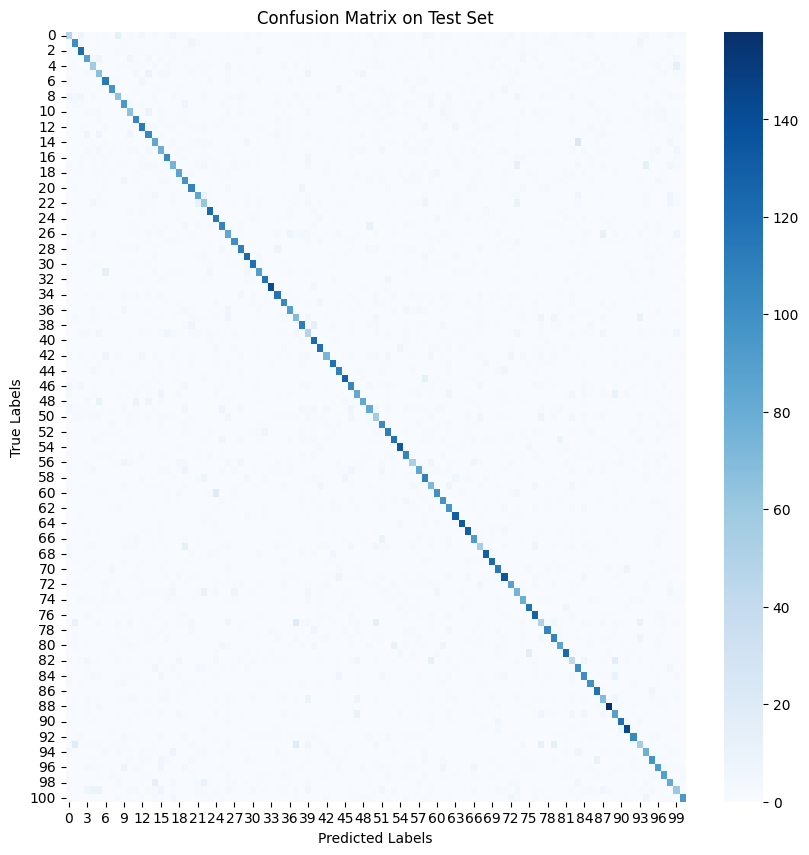

In [35]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, all_preds)
if hasattr(test_loader.dataset, 'classes'):
    labels = test_loader.dataset.classes
else:
    labels = test_loader.dataset.dataset.classes
# Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
